In [1]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
# Fetch MNIST Dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)
# mnist contains images so dataframes are not ideal
# we set as_frame=False so that we can get the Numpy arrays

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
X.shape

(70000, 784)

### Notes
- There are 70,000 images and each image has 784 features
- This is because each image has 28 x 28 pixels and each feature is a pixel's intensity. (from 0 [white] to 255 [black])

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

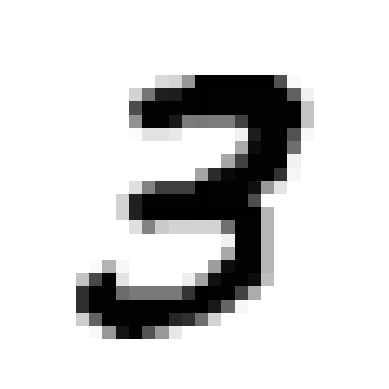

In [7]:
some_digit = X[7]
plot_digit(some_digit)
plt.show()

In [8]:
y[7]

'3'

In [9]:
# Splitting into train and test
# MNIST is automatically split into train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier (5 or Non-5)

In [10]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5') # True if 5, False if not

In [11]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [12]:
# Training a stochastic gradient descent (SGD) calssifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # Trains on all the data, but only sees true/false values as the labels (5 or not)

SGDClassifier(random_state=42)

In [13]:
# Now see how it does for some random digits (20)
import numpy as np

rand_idxs = np.random.randint(1, 60000, size=20)
for rand_idx in rand_idxs:
    if sgd_clf.predict([X_train[rand_idx]])[0] == False:
        print(f"The model predicted that this is not a 5.")
    else:
        print(f"The model predicted that this is a 5.")
    print(f"This is actually a {y_train[rand_idx]}")

The model predicted that this is not a 5.
This is actually a 1
The model predicted that this is not a 5.
This is actually a 9
The model predicted that this is not a 5.
This is actually a 2
The model predicted that this is not a 5.
This is actually a 3
The model predicted that this is not a 5.
This is actually a 1
The model predicted that this is not a 5.
This is actually a 1
The model predicted that this is not a 5.
This is actually a 9
The model predicted that this is not a 5.
This is actually a 0
The model predicted that this is not a 5.
This is actually a 1
The model predicted that this is not a 5.
This is actually a 8
The model predicted that this is not a 5.
This is actually a 9
The model predicted that this is not a 5.
This is actually a 6
The model predicted that this is not a 5.
This is actually a 4
The model predicted that this is a 5.
This is actually a 5
The model predicted that this is not a 5.
This is actually a 1
The model predicted that this is not a 5.
This is actually 

## Measuring Accuracy Using Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

While 95% accuracy may seem like a good score, it is not necessarily.

In [15]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # check if any items in list are True

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

So we can see that even the dummy classifier achieves over 90% accuracy by always guessing that the given number is NOT a 5. This is because only about 10% of the dataset are 5s. So **accuracy is not always the best performance measure for classification problems**.

## Confusion Matrices

In [18]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns the predictions made on each fold (instead of the score)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


Each row in a confusion matrix represents an actual class while each column represents a predicted class. 
To me it looks like:
- 53,892 elements that are not 5s were correcly identified as not 5s.
- 687 elements that are not 5s were incorrectly identified as 5s.
- 1891 elements that are 5s were incorrectly identified as not 5s.
- 3530 elements that are 5s were correctly identified as 5s.

So accuracy here is about (3530 + 53892) / 70000

# Precision and Recall
- **Precision**: The accuracy of the positive predictions. = TP / (TP + FP)
- **Recall (Sensitivity) (True Positive Rate)**: The ratio of positive instances that are correctly detected. = TP / (TP + FN)

In [20]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


- When our classifier claims an image represents a 5, it is correct 83.7% of the time.
- Our classifier only detects 65.1% of 5s.

## F1 Score
- This is the harmonic mean of precision and recall
- Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.
- The classifier will only get a high F1 score if both recall and precision are high.

**Increasing precision reduces recall**

In [21]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


The way SGD classifier works:
- It computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class, otherwise it assigns it to the negative class.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[-4988.52407755]


In [24]:
# We know this digit is a 3, so our classifier is
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [25]:
# If we reduce the threshold to say -5000, we will see that the precision is negatively impacted
# We incorrectly detect the false as a positive
threshold = -5000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [26]:
# To determine what threshold to use, use cross_val_predict and return decision scores instead of predictions
y_decision_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [28]:
# With these scores, use the precision_recall_curve function to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_decision_scores)

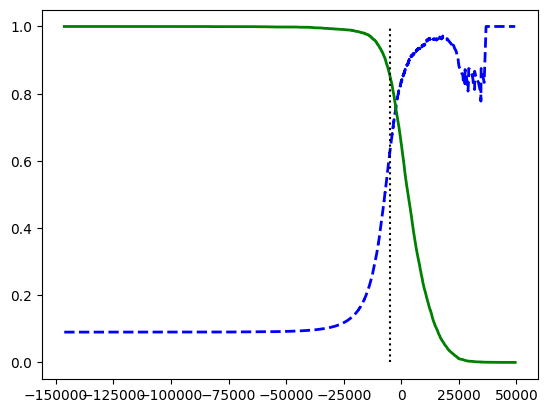

In [29]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

The choice of whether to prefer a high precision, or high recall, depends on the specific project. But you can use a graph such as this one to help make that decision.
Examples:
- Spam filter to detect spam emails:
    - It would be preferable to let a few spam filters end up in the inbox, than to have an important email misclassified as spam. Therefore, a high **precision** would be prioritized. We need to make sure that we can be really confident IF the classifier classes this as spam then it is actually spam. 
- Medical diagnostic tool to identify cases of a rare but serious disease:
    - It would be preferable to misdiagnose someone as *having* the disease, as they can always verify with follow up tests, than to have someone who actually has the disease being diagnosed as not having it. So we prefer a high **recall**. 
- For a search engine, you want it display only results relevant to the user's query:
    - We would prefer high **precision** here. It is more important that if a result is returned, it is actually relevant to the user's query than it is to ensure that we capture EVERY possible relevant result.

In [30]:
# We can search for the lowest threshold that gives you at least 90% precision.
idx_for_90_precision = (precisions >= 90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

-146348.56726173745

In [35]:
# Now instead of running the classifier's predict() method, you can run:
y_train_pred_90 = (y_decision_scores >= threshold_for_90_precision)
# This returns True for all decision scores that are greater than or equal to the minimum threshold that gives 90% precision

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.09035

In [37]:
recall_score(y_train_5, y_train_pred_90)

1.0